In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import tensorflow as tf
import csv
import seaborn as sns


import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression



## Preprocessing

In [112]:
# Import Housing Data
new_housing_csv = pd.read_csv('../data/new_housing.csv')

# Select houses with a Sale Price over $100,000
mask = (new_housing_csv["SALE PRICE"]) > 100000.0
new_housing_csv = new_housing_csv[mask]

# Only select homes sold between 2010 and 2015
new_housing_csv['SALE DATE'] = pd.to_datetime(new_housing_csv['SALE DATE'])
mask = (new_housing_csv["SALE DATE"]).dt.year > 2010 
new_housing_csv = new_housing_csv[mask]
mask = (new_housing_csv["SALE DATE"]).dt.year < 2015
new_housing_csv = new_housing_csv[mask]


# Only select important rows
new_housing_csv = new_housing_csv[["SALE PRICE", "LAND VAL", "IMPROVE VAL","SQFT", "ROOMS", "BEDROOM", "BATH", "LIVING AREA", "GROSS AREA", "YEAR", "PERCENT GOOD", "STORIES"]]

#Remove Nulls and 0s in Data
mask = new_housing_csv.notnull().all(axis=1)
new_housing_csv = new_housing_csv.loc[mask, :]
mask = (new_housing_csv != 0).all(axis=1)
new_housing_csv = new_housing_csv.loc[mask, :]

# Seperate into Data and Labels
housing_data = new_housing_csv[["LAND VAL", "SQFT", "ROOMS", "BEDROOM", "BATH", "LIVING AREA", "GROSS AREA", "YEAR","PERCENT GOOD", "STORIES"]]
housing_label = new_housing_csv[["SALE PRICE"]]

/var/folders/p6/bmvt9pvd0vd5t3yfr1yhfh580000gn/T/ipykernel_1530/121220291.py:2: DtypeWarning: Columns (13,20,53,54,59,60,61,62,63,64,65,66,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  new_housing_csv = pd.read_csv('../data/new_housing.csv')


In [113]:
X = housing_data
Y = housing_label

def normalize(X):
    """
    Normalizes the data X using the mean and standard deviation.  
    
    Parameters:
    X (np.ndarray): An array of unnormalized data.
    
    Returns:
    np.ndarray: The normalized version of the data.
    """    
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X = (X - mu) / sigma
    return X, mu, sigma

# Normalize Data
X, mu_X, sigma_X = normalize(X)
Y, mu_Y, sigma_Y = normalize(Y)

# Convert to Numpy Array
X = pd.DataFrame.to_numpy(X)
Y = pd.DataFrame.to_numpy(Y)

## Model

In [114]:
class LinearRegression(tf.keras.Model):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(units=32, activation='relu')
        self.dense4 = tf.keras.layers.Dense(units=1, kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.L2(0.01))
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)

        return x

In [115]:
model = LinearRegression()

# Loss function and Optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)

In [116]:
# Convert data to numpy arrays
X = np.asarray(X)
Y = np.asarray(Y)

# Shuffle the data and labels tensors using the same permutation

# perm = np.random.permutation(len(X))
# X = X[perm]
# Y = Y[perm]

# Convert data to tensors
X = tf.convert_to_tensor(X, dtype=tf.float32)
Y = tf.convert_to_tensor(Y, dtype=tf.float32)


# Percent of Data used for training
train_split = 0.7

# Split data into train and test
X_train = X[:int(train_split * len(X))]
Y_train = Y[:int(train_split * len(X))]
X_test = X[int(train_split * len(X) + 1):(len(X))]
Y_test = Y[int(train_split * len(X) + 1):(len(X))]


In [117]:
num_epochs = 10000
loss_visualization = []
for epoch in range(num_epochs):
    # Forward pass
    with tf.GradientTape() as tape:
        y_pred = model(X_train)
        loss = loss_fn(Y_train, y_pred)
    
    # Backward and optimize
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    loss_visualization.append(loss.numpy())
    # Print progress
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.numpy():.4f}")


Epoch [100/10000], Loss: 0.4172
Epoch [200/10000], Loss: 0.3791
Epoch [300/10000], Loss: 0.3496
Epoch [400/10000], Loss: 0.3254
Epoch [500/10000], Loss: 0.3040
Epoch [600/10000], Loss: 0.2856
Epoch [700/10000], Loss: 0.2692
Epoch [800/10000], Loss: 0.2545
Epoch [900/10000], Loss: 0.2405
Epoch [1000/10000], Loss: 0.2272
Epoch [1100/10000], Loss: 0.2150
Epoch [1200/10000], Loss: 0.2057
Epoch [1300/10000], Loss: 0.2035
Epoch [1400/10000], Loss: 0.1980
Epoch [1500/10000], Loss: 0.1863
Epoch [1600/10000], Loss: 0.1926
Epoch [1700/10000], Loss: 0.1731
Epoch [1800/10000], Loss: 0.1788
Epoch [1900/10000], Loss: 0.1722
Epoch [2000/10000], Loss: 0.1690
Epoch [2100/10000], Loss: 0.1577
Epoch [2200/10000], Loss: 0.1634
Epoch [2300/10000], Loss: 0.1546
Epoch [2400/10000], Loss: 0.1431
Epoch [2500/10000], Loss: 0.1366
Epoch [2600/10000], Loss: 0.1327
Epoch [2700/10000], Loss: 0.1313
Epoch [2800/10000], Loss: 0.1293
Epoch [2900/10000], Loss: 0.1374
Epoch [3000/10000], Loss: 0.1395
Epoch [3100/10000],

In [118]:
def accuracy(y_pred, y_true, sigma, mu, threshold=0.2):
    """
    Computes the accuracy of the predictions given the true labels, based on a threshold value.
    
    Parameters:
    y_pred (np.ndarray): An array of predicted labels.
    y_true (np.ndarray): An array of true labels.
    threshold (float): The threshold value to use for measuring accuracy.
    
    Returns:
    float: The accuracy of the predictions as a percentage.
    """
    # Compute the absolute difference between predicted and true values
    
    
    y_pred = (y_pred * sigma) + mu
    y_true = (y_true * sigma) + mu

    diff = np.abs(y_pred - y_true)
    
    # Compute accuracy
    acc = np.mean(diff <= threshold * y_pred)
    
    # Convert to percentage
    acc_pct = acc * 100
    
    return acc_pct

In [119]:
pred = model(X_train)
loss = loss_fn(Y_train, pred)
print("Training Accuracy:", accuracy(pred, Y_train, sigma_Y, mu_Y))

pred = model(X_test)
loss = loss_fn(Y_test, pred)
print("Testing Accuracy:", accuracy(pred, Y_test, sigma_Y, mu_Y))


Training Accuracy: 86.19181505779444
Testing Accuracy: 77.5346462436178


## Visualizations


#### Loss vs. Epoch Number

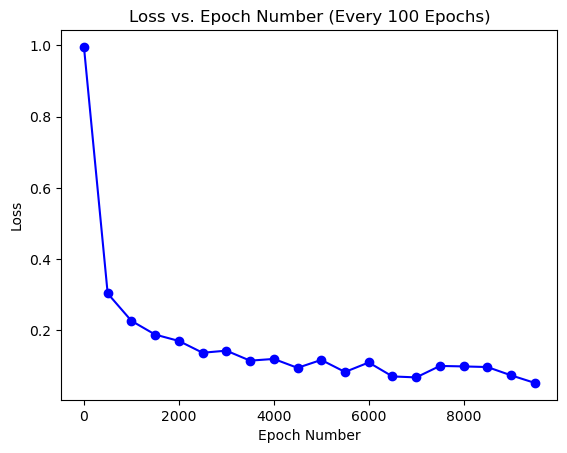

In [120]:
plt.figure()

plt.title('Loss vs. Epoch Number (Every 100 Epochs)')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.plot(range(1, len(loss_visualization)+1, 500), loss_visualization[::500], 'bo-')

plt.show()

#### Threshold Analysis

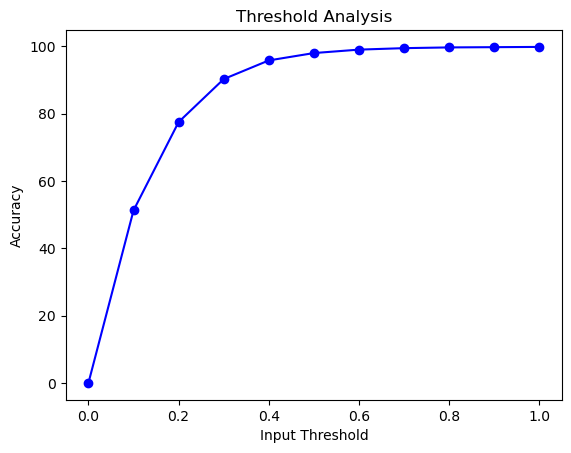

In [121]:
input_threshold = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
output_accuracy = []
for i, threshold in enumerate(input_threshold):
    acc = accuracy(pred, Y_test, sigma_Y, mu_Y, threshold=threshold)
    output_accuracy.append(acc)
    
# Create the plot
plt.plot(input_threshold, output_accuracy, '-bo')

# Add a title and labels to the axes
plt.title('Threshold Analysis')
plt.xlabel('Input Threshold')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

#### Scatter Plot (Predicted vs. Actual)

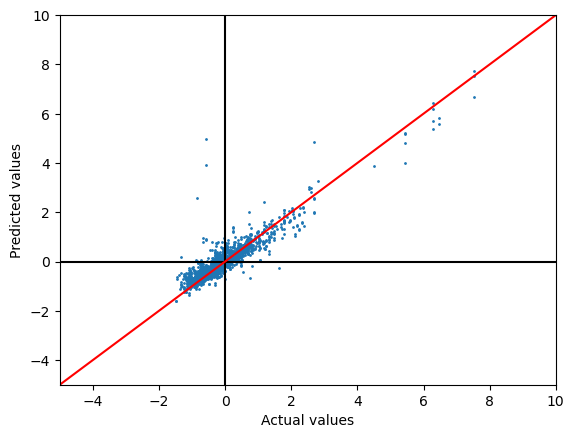

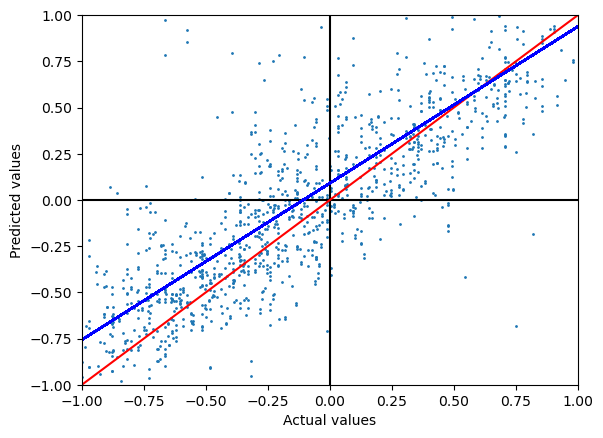

In [122]:
plt.scatter(Y_test, pred, s=1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.ylim(-5, 10)
plt.xlim(-5, 10)

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

x = np.linspace(*plt.xlim())
plt.plot(x, x, color='r')

plt.show()

## Zoomed in Graph
plt.scatter(Y_test, pred, s=1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.ylim(-1, 1)
plt.xlim(-1, 1)

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

x = np.linspace(*plt.xlim())
plt.plot(x, x, color='r')

m, b = np.polyfit(np.asarray(Y_test).flatten(), np.asarray(pred).flatten(), 1)
plt.plot(Y_test, m*Y_test + b, color='b', linestyle='--')


plt.show()

####  Frequency on Housing Data

/var/folders/p6/bmvt9pvd0vd5t3yfr1yhfh580000gn/T/ipykernel_1530/4094863270.py:1: DtypeWarning: Columns (13,20,53,54,59,60,61,62,63,64,65,66,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/new_housing.csv')


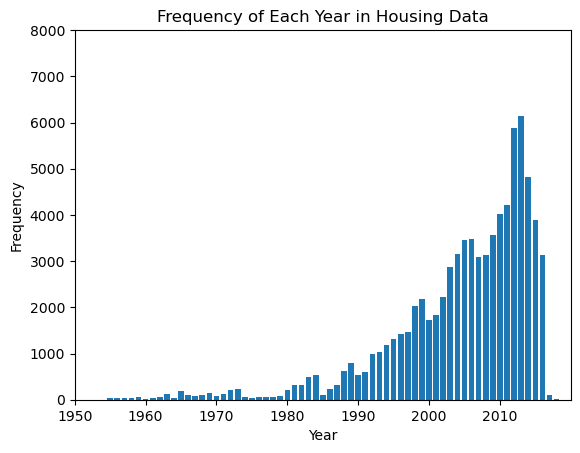

In [123]:
df = pd.read_csv('../data/new_housing.csv')

# Create a frequency table of the "YEAR" column
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

year_freq = df['SALE DATE'].dt.year.value_counts()


# Create a bar plot
plt.bar(year_freq.index, year_freq.values)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Each Year in Housing Data')


plt.ylim(0, 8000)
plt.xlim(1950, year_freq.index.max())

plt.xticks(range(1950, 2020, 10))#### Scatter Plot


# Display the plot
plt.show()

#### Heatmap of Variables

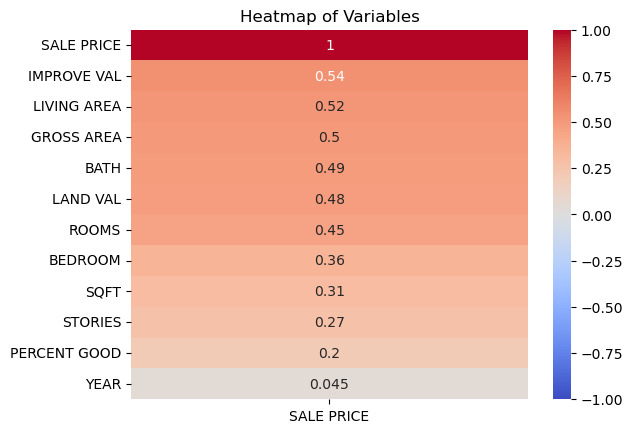

In [124]:
target_col = "SALE PRICE"

corr_matrix = new_housing_csv.corr()[[target_col]]

corr_matrix = corr_matrix.sort_values(by=target_col, ascending=False)

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0).set(title='Heatmap of Variables')

plt.show()
